# Trabalho Prático nº3 - BIKE - Grupo 8

No âmbito do trabalho prático nº3, foi nos pedido para implementar o algoritmo **BIKE**, candidato ao concurso *NIST Post-Quantum Cryptography*. O algoritmo implementado é baseado na **última** documentação disponível no website deste candidato ([Bike_Spec.2022.10.10.1](https://bikesuite.org/files/v5.0/BIKE_Spec.2022.10.10.1.pdf)). Posteriormente, para a implementação do PKE, iremos utilizar a transformação de Fujisaki-Okamoto apresentada no Capítulo 2.a da documentação da UC. 

## BIKE (Bit Flipping Key Encapsulation) - KEM(IND-CPA):

Para este exercício, começamos por implementar o KEM definido na documentação. Esta classe implementada poderá ser dividida em três:
1. KeyGen
2. Encapsulamento da chave de sessão
3. Desecapsulamento da chave de sessão

Estas partes foram implementadas como indicado mo algoritmo da tabela 3 da página 3 da documentação indicada e pode ser vista de seguida:

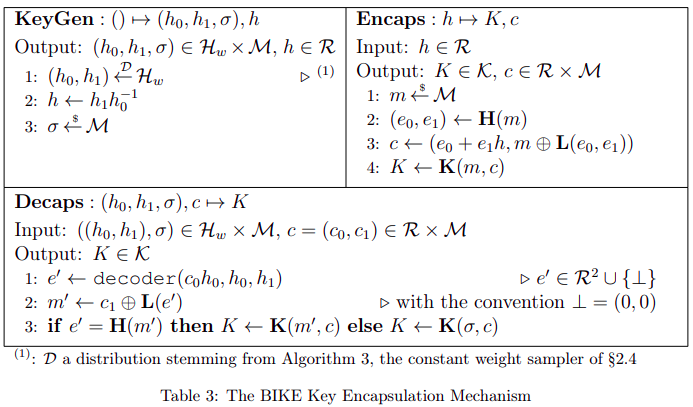

### Implementação:


* **Setup**:

Antes de implementar as funções apresentadas anteriormente, é necessário inicializar a classe. Esta classe deverá ser inicializada com quatro parâmetros, três funções hash e um *decoder*.

Os parâmetros que iremos inicializar são o *r*, *w*, *t*, *l*. Na página 7, da documentação são apresentados três possíveis valores para cada uma das variáveis. Estes possíveis valores corresponderam a diferentes níveis de segurança. No entanto, para este exemplo acadêmico, iremos inicializar estas variáveis com os valores: *l* = 256, *r* = 257, *t* = 16 e *w* = 6. 

Adicionalmente, definimos também um anel de polinomos ciclico como apresentado na seguinte tabela:

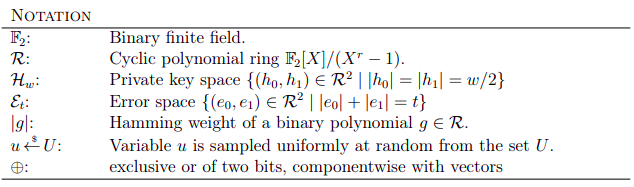

Para além disto, foi necessário implementar trÊs funções hash **H**, **K** e **L**. Na nossa implementação definimos as seguintes funções:

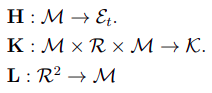

A função **H** permite gerar, a partir de um valor *random*, um par de valores de erros. A função **K** será uma função que irá gerar um valor do tipo *key* a partir do seu encapsulamento e de um valor aleatório. Por último, definimos a função **L** que a partir do valor dos erros gerados pela função H irá gerar um valor *hash* da concatenação de ambos.

Para auxiliar estas funções foi necessário criar uma função **WSHAKE256-PRF**(seed,len,wt), defina, da seguida forma:

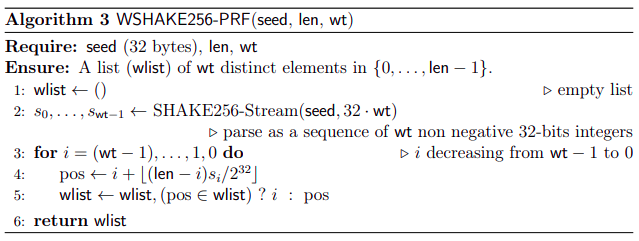

Por último, foi necessário definir o **decoder**. Ora, o algoritmo **BIKE** é um algoritmo que se baseia num problema de descodificação de códigos lineares de baixa densidade e em códigos QC-MDPC (Quasi-Cyclic Moderate Density Parity-Check). Assim, para que seja possível realizar a descodificação é necessário desenvolver uma função que seja capaz de resolver problemas deste tipo. Assim, a função *decoder* será uma função cujo algoritmo é do tipo **Bit-Flip**. Para a nossa solução, apresentados duas funções deste tipo, sendo estes o *BitFlip* presente nos apontamentos do Capítulo 9 e o *Black-Gray-Flip* definido na documentação do algoritmo *BIKE*, mencionado anteriormente.

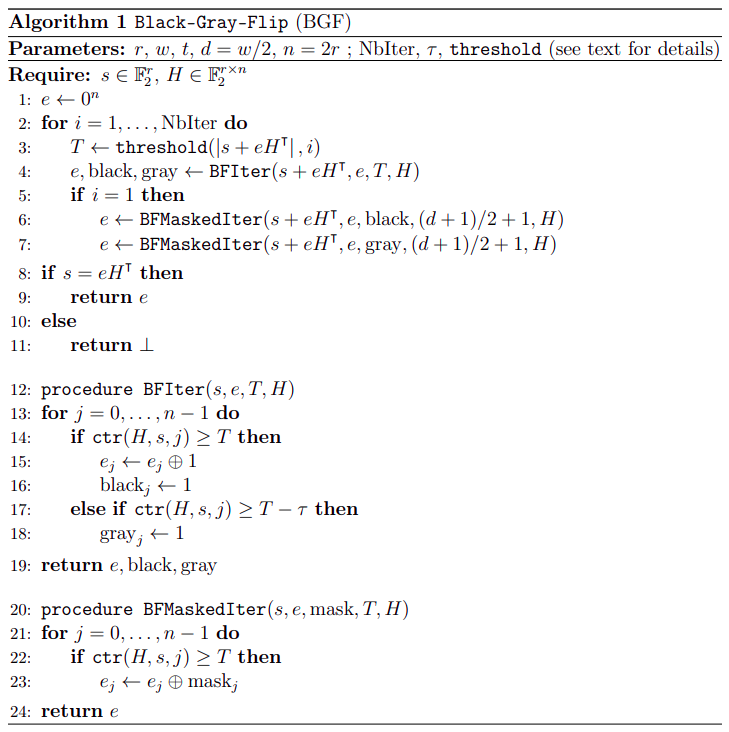

Contudo, apesar de ambos os algoritmos se encontrarem implementados, estes *decoders* não se encontram completamente operacionais. Isto é, na versão atual, para que seja possível testar os restantes parâmetros da implementação, estes decoders foram ignorados, visto que não eram capazes de solucionar o problema de descodificação de códigos lineares de baixa densidade da nossa implementação.

Assim, este algoritmo deverá possuir um **decoder** tal que:
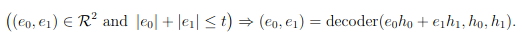

Assim, o *decoding* do KEM será resolvido pelo *decoder*. Este *decoder* deverá receber um *s* (*syndrome*) e um (h0, h1) e retornar (e0, e1), tal que e0*h0 + e1*h1 = s ou *failure*.


* **KeyGen**:
Este algoritmo começa por gerar os valores da chave privada (h0, h1). Como podemos verificar, estes valores vão ser gerados de acordo com uma distribuição D sobre $H_{w}$. Sabendo que serão gerados sobre $H_{w}$, sabemos que estes valores deverão pertecer a *R* e ter pesos de Hamming = *w*/2. Para evitar duplicação, esta distribuição irá usar o algoritmo 3 com os valores (r, w/2), como recomendado na página 5 da documentação.

De seguida, iremos obter a chave pública. Como podemos ver na tabela anterior, a chave pública *h*, será gerada pela multiplicação do primeiro valor da chave privada pela inversa do segundo valor. Por último, é gerado um valor para *sigma* de l-bits e gerado aleatoriamente.

* **Encaps**:

De seguida, implementamos a função do KEM que gera uma chave de sessão e o seu encapsulamento. Esta função começa com a criação de um valor de l-bits aleatório (**m**) que será posteriormente passado como argumento para a função **H**, como apresentado na tabela 3. O resultado desta função serão dois polinómios pertencentes ao anel *R*, cuja a soma do peso de Hamming destes dois valores será igual *t*.

Com estes valores, geramos o valor do encapsulamento conforme apresentado no ponto 3 da função *Encaps* da tabela 3. Por último, geramos o valor da chave, recorendo à função K cujos os argumentos serão **m** e 
o encapsulamento. O resultado desta função será a chave de sessão e o par-encapsulamento.

* **Decaps**:

A última parte deste algoritmo **BIKE** será o desencapsulamento da chave de sessão. Este algoritmo começa por utilizar a função **decoder** apresentada anteriormente, que deverá devolver o valor dos erros. Estes erros serão passados como argumento para a função **L** e que, juntamente com o segundo valor do encapsulamento, irá devolver o valor aleatório utilizado na função *Encaps*. Se os erros gerados pela função **H** com este valor aletório recuperado gerarem os mesmos valores de erro obtidos pela função *decoder*, poderemos obter o valor da chave de sessão.

Passamos agora à análise do código.

In [1]:
def setup_parameters(level):
    l = 256
    r = -1
    w = -1
    t = -1
    NbIter = 5 # number of iterations of decoder
    tau = 3    # threshold gap of decoder: size of the "gray" set of positions 
    if(level == 1):
        r = 257 #12323 #
        w = 6   # 142  #
        t = 16  # 134  # 
        
    elif(level == 3):
        r = 24659
        w = 206
        t = 199
        
    elif(level == 5):
        r = 40973
        w = 274
        t = 264
    
    return r,w,t,l,NbIter,tau

def R(r):
    # Cyclic Polynomial Ring F2[x]/(x^r -1)
    # Baseado no Notebook AlgebraAbstrata da diretoria da disciplina    
    F = PolynomialRing(GF(2), name = 'x')
    x = F.gen()
    Rf.<x> = QuotientRing(F, F.ideal(x^r - 1))
    return Rf

In [2]:
class decoder:
    
    def __init__(self, h0, h1, s, n, r, w, tau):
        self.h0 = h0
        self.h1 = h1
        self.s = s
        self.n = n
        self.r = r
        self.w = w
        self.tau = tau

    def hammingWeight(self,x):
        return sum([1 if a == 1 else 0 for a in x])
        

    def bit_flip(self, H, s):
        # output e
        # ensures s = e*Ht; s = c0*h == e0*h0+e1*h1 <=> (v(e0)*v(h0)+v(e1)*v(h1)) == s = e*Ht = (e0,e1) * (h0,h1)
        n = 2*self.r
        s_aux = vector(s); s = vector(s); e_aux = vector([0]*n)
        nIter = self.r
        Ht = H.T
        
        while self.hammingWeight(s_aux) != 0 and nIter > 0: # - e_aux * Ht
            nIter = nIter-1;
            
            weights = [self.hammingWeight((H.column(i)).pairwise_product(s_aux)) for i in range(n)]
            maximum = max(weights)            
            
            count = 0
            for j in range(0, n):
                
                if self.hammingWeight((H.column(j)).pairwise_product(s_aux)) >= maximum:
                    e_aux[j] = 1 - e_aux[j]
                    s_aux += H.column(j)
              
        if nIter == 0:
            return None
        
        return e_aux
    
    def decoderBitFlip(self):
        H0 = matrix.circulant(self.h0.list())
        H1 = matrix.circulant(self.h1.list())
        H  = block_matrix(1,2,[H0,H1]) # 514 linhas 257 colunas 
        Ht = block_matrix(2,1,[H0,H1])
        return self.bit_flip(H, self.s)
   

    # threshold selection rule
    # depends on the syndrome weigth S, iteration number i and on system parameters
    def threshold(self, S, level):
        val = -1
        if level == 1:
            val = 10 #floor(0.0069722 * S + 13.530) # max(, 36)
        
        elif level == 3:
            val = floor(0.005265 * S + 15.2588) # max(, 52)
        
        elif level == 5:
            val = floor(0.00402312 * S + 17.8785) # max(, 69) 
        return val  
    
    # returns the number of unsatisfied parity-checks
    # the number of bit 1 that appear in the same position in the syndrome and in the j-th column of the matrix H
    def ctr(self, H, s, j):
        count = 0
        count = self.hammingWeight(s.pairwise_product(H.column(j)))  
        return count
    
    def recompute_syndrome(self, s, j, h):
        for i in range(self.r):
            if h[i] <= j:
                s[j - h[i]] ^= 1
            else:
                s[self.r - h[i] + j] ^= 1
        return s
                    

    def BFIter(self, s, e, T, H, n):
        black = [0]*n
        gray = [0]*n
        aux_val = T-self.tau
        pos = [0]*n
    
        for j in range(0, n):
            val = self.ctr(H, s, j)
            if val >= T:
                e[j] = e[j] ^^ 1
                pos[j] = 1
                black[j] = 1
            elif val >= aux_val:
                pos[j] = 1
                gray[j] = 1
                
        for j in range(n):
            if pos[j] == 1:
                s = self.recompute_syndrome(s, j, H.column(0))       
        return s, e, black, gray
    
    
    def BFMaskedIter(self, s, e, mask, T, H, n):
        for j in range(0, n):
            if self.ctr(H,s,j) >= T and mask[j] == 1:
                e[j] = e[j] ^^ 1
                s = recompute_syndrome(s, j, H.column(0));
        return s, e
   

    def decoderBGF(self):
        d = self.w/2
                         
        H0 = matrix.circulant(self.h0.list())
        H1 = matrix.circulant(self.h1.list())
        H  = block_matrix(1,2,[H0,H1]) # 514 linhas 257 colunas 
        Ht = block_matrix(2,1,[H0,H1])
            
        s_a = vector(self.s)
        e_a = vector([0]*self.n)
        
        while i < self.r+1 and self.hammingWeight(s_a) != 0:
            T = self.threshold(self.hammingWeight(s_a), 1)
            s_a, e_a, black, gray = self.BFIter(s_a, e_a, T, H, self.n)
            if i == 1:
                s_a, e_a = self.BFMaskedIter(s_a, e_a, black, (d+1)/2 + 1, H, self.n)
                s_a, e_a = self.BFMaskedIter(s_a, e_a, gray, (d+1)/2 + 1, H, self.n)
        
        if s_a == e_a * Ht:
            return e
        else: 
            return None
    

In [3]:
from cryptography.hazmat.primitives import hashes
import random


class BIKE:
    def __init__(self, level):
        self.private = 0
        self.level = level
        self.r, self.w, self.t, self.l, self.NbIter, self.tau = setup_parameters(level)
        self.R = R(self.r)
        
        # Para remediar o decoder:
        self.e0 = 0
        self.e1 = 0
    
    # Returns a list (wlist) of wt distint elements in {0,..., len-1}
    # seed: 32 bytes!
    def WSHAKE256_PRF(self, seed, l, wt):
        wlist = [0]*l
        digest = hashes.Hash(hashes.SHAKE256(int(4*wt))) # SHAKE will return wt 32-bit ints
        digest.update(seed)
        elems = digest.finalize() # SHAKE256-Stream(seed, 32*wt)
        s = [elems[i:i+4] for i in range(0, 4*wt, 4)]
        for i in range((wt-1), -1, -1): # Da pos wt-1 até 0
            si = int.from_bytes(s[i],byteorder = "little")
            pos = i + floor((l-i)*si/2^32)
            if wlist[pos] != 0:
                wlist[i] = 1
            else:
                wlist[pos] = 1
        return wlist    
    
    def is_invertible(self, h):
        try:
            aux = 1/h
            return True
        except ZeroDivisionError:
            return False
        
        
    def Hw(self):
        HW = self.w/2
        h0 = 0
        h1 = 0
        while h0 == 0 or not self.is_invertible(h0):
            seed = os.urandom(self.l/8)
            coeffs_h0 = self.WSHAKE256_PRF(seed, self.r, HW)
            h0 = self.R(coeffs_h0)
            
        while h1 == 0 or not self.is_invertible(h1):
            seed = os.urandom(self.l/8)
            coeffs_h1 = self.WSHAKE256_PRF(seed, self.r, HW)
            h1 = self.R(coeffs_h1)             
             
        return h0,h1
    
    # returns a random value of l bits
    def M(self):
        sigma = os.urandom(self.l/8)
        return sigma
    
    
    def H(self, m):
        # Make sure m is a 32 byte input
        
        e = self.WSHAKE256_PRF(m, self.r*2, self.t)
        e0_a = e[:self.r]; e0 = self.R(e0_a)
        e1_a = e[self.r:]; e1 = self.R(e1_a)
        return e0, e1
    
        
    def bytes_coeff(self,i, size):
        conc = ''.join(map(str, i))
        conc = [(int(conc[i:i+8], base = 2).to_bytes(8,'little')) for i in range(0, size, 8)]
        conc = b' '.join(conc)
        return conc
    
    
    def L(self, e0, e1):
        e0_coef = e0.list()
        e1_coef = e1.list()
        conc = e0_coef + e1_coef
        conc = self.bytes_coeff(conc, 2*self.r)
        
        digest = hashes.Hash(hashes.SHA384())
        digest.update(conc)
        val = digest.finalize()
        val = val[-self.l/8:] # least 32 significant bytes
        
        return val
    
    # message and key should be bytes
    def xor(self, message, key):
        output = bytes([x ^^ y for(x,y) in zip(message, key)])   
        return output
    
    # m: bytes, c0 in R, c1: bytes
    def K(self, m, c):
        (c0, c1) = c
        bytes_c0 = self.bytes_coeff(c0.list(), self.r)
        lst = [m, bytes_c0, c1]
        conc = b''.join(lst)
        
        digest = hashes.Hash(hashes.SHA384())
        digest.update(conc)
        val = digest.finalize()
        val = val[-self.l/8:]
        return val
                   
    def hammingWeight(self,x):
        return sum([1 if a == 1 else 0 for a in x])
        
    # This function returns the private key (h0, h1, theta) and the public key (h)
    def KeyGen(self):
        (h0, h1) = self.Hw()
        h_aux = h1*h0.inverse()
        h = self.R(h_aux)
        sigma = self.M()
        self.private = (h0, h1, sigma)
        return self.private, h
    
    def Encaps(self, public_key):
        m = self.M() # 32 bytes
        e0, e1 = self.H(m)
               
        self.e0 = e0
        self.e1 = e1
        
        c0 = e0 + e1*public_key
        c1 = self.xor(m , self.L(e0,e1))# ; c1 = self.R(c1)         
        key = self.K(m, (c0, c1))
        
        return key, (c0, c1)
        
        
    def Decaps(self, encap):
        (c0, c1) = encap # c1 256 bits
        (h0, h1, sigma) = self.private
                
        dec = decoder(h0, h1, (c0*h0), (2*self.r), self.r, self.w, self.tau)
        # e = dec.decoderBitFlip()
        e = self.e0.list()+self.e1.list()
        
        if e == None:
            print("Erro")
            e_0 = self.R(0)
            e_1 = self.R(0)
        else:
            e_0 = self.R(e[:self.r]); e_1 = self.R(e[-self.r:])
        
        m_ = self.xor(c1, self.L(e_0, e_1)) # m_ 256 bits
        e0_a, e1_a = self.H(m_)
        
        if e_0 == e0_a and e_1 == e1_a:
            key = self.K(m_, encap)
        else:
            key = self.K(sigma, encap)
        return key
        


### Testes:

In [4]:
bike = BIKE(1)
(h0, h1, sigma), public = bike.KeyGen()
key, encap              = bike.Encaps(public)
key1                    = bike.Decaps(encap)

if key == key1:
    print("Encaps and Decap is correct")
else:
    print("Encap and Decap not correct")

Encaps and Decap is correct


## PKE

A partir da implementação do *KEM* (*IND-CPA*), e com a transformação de *Fujisaki-Okamoto* (**FOT**),
consegue-se desenvolver um protótipo para um algoritmo **PKE** que seja **IND-CCA**;
tal com pedido no enunciado.

Primeiro, é necessário decompor o KEM em duas funções, um *hash* aleatório e a restante função (*f*) que usa esse valor da *hash* (parte deterministica).

Deste modo, segue-se o **esquema assimétrico**, *E'* e *D'*, respetivos
ao método de **cifra** e **decifra** do novo *PKE IND-CPA*.

#### Método 'Encrypt'

Como encontra-se especificado no **Capítulo 2a**, o método de cifra (*tweaked* com a *FOT*), segue:

$$E'(x)\;\equiv\;\vartheta\,r \gets h\,\centerdot\,\vartheta\,y \gets x\oplus g(r)\,\centerdot\, (e,k) \gets f(y\|r)\,\centerdot\,\vartheta\,c\gets k\oplus r\,\centerdot\,(y, e, c)$$

Concretamente:

1. Inicia-se o processo com a criação de um valor aleatório *r*, usando o método *M* da classe *KEM* (devolvendo um valor **32 bytes**);
2. Para calcular o valor *y*, é necessário realizar o *XOR* entre a mensagem, *m* (valor x na equação), e o *hash* do valor aleatório *r*;
3. Utilizou-se, então, o método de *hashing SHAKE256* para calcular o valor *g(r)* a ser usado na operação de *XOR*. Este g(r) será do mesmo tamanho que a mensagem a cifrar;
4. Calcula-se o tuplo *(e,k)* a partir da função *f* mencionada no inicio (o argurmento será o valor *hash* da concatenção do valor *y* com o valor aleatório *r* e a chave pública *pk*);
5. O retorno da função é o tuplo *(y,e,c)*, sendo que *c* é o resultado de aplicar um *XOR* no valor *k* com *r*. 

Assim, o criptograma retornado é composto por uma variável **c** (ofuscação da chave), **y** (ofuscação da mensagem)
e **e** (encapsulamento da chave).
A **ofuscação da chave e da mensagem** (*c* e *y*) vão permitir ao utilizador a
capacidade de, após a transmissão, decifrar e obter a mensagem inicial.
O valor *c* atuará com um meio para verificar a validade/autenticidade da 
mensagem, após transmitida, i.e. se foi ou não alterada (análogo a um código *HMAC*).

#### Método 'Decrypt'

Também no **Capítulo 2a**, o método *Decrypt*, *tweaked* pela transformação *FOT* aplicada ao 
*KEM IND-CPA*, têm a sua fórmula descrita.

O algoritmo de **decifra**, segue:
$$D'(y,e,c) \;\equiv\;\vartheta\,k \gets \mathsf{KREv}(e)\,\centerdot\,\vartheta\,r \gets c \oplus k\,\centerdot\,\mathsf{if}\;\;(e,k)\neq f(y\|r) \;\;\mathsf{then}\;\;\bot\;\;\mathsf{else}\;\;y \oplus g(r)$$

Neste caso:

1. Utilizou-se o método *Decaps* do *KEM* (desencapsulamento da chave, *KRev*), para obter a chave *k*;
2. Análogo ao processo de cifragem, *E'*, utilizou-se os valores *c* (ofuscação da chave) e *k* (chave), numa operação de *XOR*, para obter o valor *y*;
3. Analogamente, calcula-se o tuplo *(k, e)* através de aplicar a função *f* no restado *hash* da concatenação de *y* com *r* e na chave pública *pk*;
4. Compara-se os valores *k* e *e* óbtidos com os que são recebidos no **criptograma** (argumento do *Decrypt*);
    1. Falha caso não sejam.
5. Se são valores válidos retorna-se o resultado de aplicar um *XOR* entre *y* e *g(r)*, a **mensagem decifrada**.

In [5]:
kem = BIKE(1)
class PKE:
    def __init__(self):
        self.kem = BIKE(1)
    
    def f(self, value, pk):
        e0, e1 = self.kem.H(value)        
        self.kem.e0 = e0
        self.kem.e1 = e1
        c0 = e0 + e1*pk
        c1 = self.kem.xor(value , self.kem.L(e0,e1))# ; c1 = self.R(c1)         
        key = self.kem.K(value, (c0, c1))
        return key, (c0, c1)
        
    
    def KeyGen(self):
        self.sk, self.pk = self.kem.KeyGen()
        return self.sk, self.pk
        
    def Encrypt(self, message, pk):
        # r <- h
        r = self.kem.M() # 32 bytes
            
        # g = g(r)
        size = len(message)
        h = hashes.Hash(hashes.SHAKE256(size))
        h.update(r)
        g = h.finalize()
                
        # y <- xor(x, g(r)) 
        y = self.kem.xor(message.encode('utf-8'), g)
        
        # (e,k) <- f(y || r)
        conc_message = y + r  # bytes
        
        # Size down the mensage to 32 bytes
        digest = hashes.Hash(hashes.SHAKE256(int(32))) # SHAKE will return wt 32-bit ints
        digest.update(conc_message)
        elems = digest.finalize()
                
        k, (e0, e1) = self.f(elems, pk)
    
        c = self.kem.xor(k, r)
           
        return (y, (e0,e1), c)
    
    
    def Decrypt(self,ciphertext):
        (y, (e0,e1) , c) = ciphertext
               
        # k <- KREv(e)
        k = self.kem.Decaps((e0,e1))
        
        
        r = self.kem.xor(c, k)
        
        concate_message = y + r
        
        digest = hashes.Hash(hashes.SHAKE256(int(32))) # SHAKE will return wt 32-bit ints
        digest.update(concate_message)
        elems = digest.finalize()
    
        (k_,(e_0,e_1)) = self.f(elems, self.pk)
        if e0 != e_0 or e1 != e_1 or k != k_:
            return None
        else: 
            # g = g(r)
            size = len(y)
            h = hashes.Hash(hashes.SHAKE256(size))
            h.update(r)
            g = h.finalize()
            return self.kem.xor(y, g)
    

### TESTES:

In [6]:
pke = PKE()
sk, pk = pke.KeyGen()

# TESTE 1:
message = "Exemplo de uma troca correta de mensagem"
print(f" 1º teste com o input = {message}")
ciphertext = pke.Encrypt(message, pk)
decrypted_text = pke.Decrypt(ciphertext)
if decrypted_text != None:
    print(f"Sucesso! Mensagem recebida: {decrypted_text.decode('utf-8')}\n ")
else:
    print("Falhou!\n")

# TESTE 2:
message = "Exemplo de uma mensagem que foi alterada, para testar a tag"
print(f" 2º teste com o input = {message}")
(y, encap, c) = pke.Encrypt(message, pk)
y1 = y[:-1] # y1 terá menos um caracter
decrypted_text = pke.Decrypt((y1, encap, c)) #espera-se que falhe
if decrypted_text == None:
    print("Falhou como esperado")
else:
    print("Sucesso. Verificação se a mensagem foi alterada falhou.")


 1º teste com o input = Exemplo de uma troca correta de mensagem
Sucesso! Mensagem recebida: Exemplo de uma troca correta de mensagem
 
 2º teste com o input = Exemplo de uma mensagem que foi alterada, para testar a tag
Falhou como esperado
